# ML Models Visualization and Evaluation

This notebook provides comprehensive visualizations for traditional ML models (XGBoost, RandomForest, LogisticRegression) for both beat and rhythm classification tasks.

## Contents
1. Setup and Data Loading
2. Load ML Model Predictions
3. Beat Classification Visualizations
   - Input: HRV features per window, feature distributions
   - Output: Predictions, probabilities, confusion matrix, ROC/PR curves
   - Model comparison: XGBoost vs RandomForest vs LogisticRegression
4. Rhythm Classification Visualizations
   - Input: HRV features per window, feature distributions
   - Output: Predictions, probabilities, confusion matrix, ROC/PR curves
   - Model comparison: XGBoost vs RandomForest vs LogisticRegression

## Models Compared
- **XGBoost**: Gradient boosting classifier
- **RandomForest**: Random forest classifier
- **LogisticRegression**: Logistic regression classifier

## Data Format
- **Input**: Window-level HRV features (60-beat windows)
- **Evaluation**: Window-level (matching DL models for fair comparison)


## Section 1: Setup and Imports


In [10]:
# Import libraries
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import label_binarize

from preprocess import (
    load_all_cases, create_sequence_dataset
)

from feature_extractor import extract_hrv_features

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## Section 2: Load ML Model Predictions


In [11]:
# Helper function to find prediction files
def find_prediction_file(filename):
    """Find prediction file in multiple possible locations."""
    current_dir = os.getcwd()
    possible_paths = [
        os.path.join(current_dir, 'experiments', 'results', 'predictions', filename),
        os.path.join(current_dir, '..', 'experiments', 'results', 'predictions', filename),
        os.path.join(current_dir, 'arrdb', 'experiments', 'results', 'predictions', filename),
        os.path.abspath(os.path.join('..', 'experiments', 'results', 'predictions', filename)),
    ]
    
    # Also try absolute path from project root
    if 'Vital_sign_Dataset' in current_dir:
        parts = current_dir.split(os.sep)
        arrdb_idx = parts.index('arrdb') if 'arrdb' in parts else -1
        if arrdb_idx >= 0:
            base_dir = os.sep.join(parts[:parts.index('Vital_sign_Dataset') + 1])
            possible_paths.append(os.path.join(base_dir, 'Vital_sign_Dataset', 'arrdb', 'experiments', 'results', 'predictions', filename))
    elif 'arrdb' in current_dir:
        parts = current_dir.split(os.sep)
        if 'arrdb' in parts:
            arrdb_idx = parts.index('arrdb')
            base_dir = os.sep.join(parts[:arrdb_idx + 1])
            possible_paths.append(os.path.join(base_dir, 'experiments', 'results', 'predictions', filename))
    
    for path in possible_paths:
        if os.path.exists(path):
            return path
    return None

# Load ML model predictions
print("📂 Loading ML model predictions...")

beat_ml_path = find_prediction_file('beat_classification_ml_predictions.pkl')
rhythm_ml_path = find_prediction_file('rhythm_classification_ml_predictions.pkl')

# Load beat predictions
beat_ml_predictions = None
if beat_ml_path and os.path.exists(beat_ml_path):
    with open(beat_ml_path, 'rb') as f:
        beat_ml_predictions = pickle.load(f)
    print(f"✅ Loaded beat ML predictions from: {beat_ml_path}")
    print(f"   Model: {beat_ml_predictions.get('model_name', 'Unknown')}")
else:
    print(f"⚠️  Beat ML predictions not found. Please run trad_ml.ipynb first.")

# Load rhythm predictions
rhythm_ml_predictions = None
if rhythm_ml_path and os.path.exists(rhythm_ml_path):
    with open(rhythm_ml_path, 'rb') as f:
        rhythm_ml_predictions = pickle.load(f)
    print(f"✅ Loaded rhythm ML predictions from: {rhythm_ml_path}")
    print(f"   Model: {rhythm_ml_predictions.get('model_name', 'Unknown')}")
else:
    print(f"⚠️  Rhythm ML predictions not found. Please run trad_ml.ipynb first.")

print("\n✅ Prediction loading complete!")


📂 Loading ML model predictions...
✅ Loaded beat ML predictions from: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/notebooks/../experiments/results/predictions/beat_classification_ml_predictions.pkl
   Model: XGBoost
✅ Loaded rhythm ML predictions from: /home/orlab/GIT_PROJECT/Vital_sign_Dataset/arrdb/notebooks/../experiments/results/predictions/rhythm_classification_ml_predictions.pkl
   Model: LogisticRegression

✅ Prediction loading complete!


## Section 3: Load Input Features (HRV Features from Windows)


In [12]:
# Load data to extract HRV features from windows (matching ML model inputs)
print("📂 Loading data for feature visualization...")
annotations_dict, metadata_df = load_all_cases()

print(f"\n✅ Dataset loaded:")
print(f"   Total patients: {len(annotations_dict)}")
print(f"   Total beats: {metadata_df['total_beats'].sum():,}")

# Create windows (same as used in ML models)
print("\n📊 Creating windows for feature extraction...")
beat_sequences, beat_labels, beat_patient_ids = create_sequence_dataset(
    annotations_dict, metadata_df, window_size=60, stride=30, task='beat'
)

rhythm_sequences, rhythm_labels, rhythm_patient_ids = create_sequence_dataset(
    annotations_dict, metadata_df, window_size=60, stride=30, task='rhythm'
)

print(f"\n✅ Windows created:")
print(f"   Beat windows: {len(beat_sequences)}")
print(f"   Rhythm windows: {len(rhythm_sequences)}")

# Extract HRV features from windows (same as ML model inputs)
print("\n📊 Extracting HRV features from windows...")
beat_hrv_features = []
for i, window_rr in enumerate(beat_sequences):
    hrv_feat = extract_hrv_features(window_rr)
    hrv_feat['window_idx'] = i
    hrv_feat['label'] = beat_labels[i]
    beat_hrv_features.append(hrv_feat)

rhythm_hrv_features = []
for i, window_rr in enumerate(rhythm_sequences):
    hrv_feat = extract_hrv_features(window_rr)
    hrv_feat['window_idx'] = i
    hrv_feat['label'] = rhythm_labels[i]
    rhythm_hrv_features.append(hrv_feat)

beat_features_df = pd.DataFrame(beat_hrv_features)
rhythm_features_df = pd.DataFrame(rhythm_hrv_features)

print(f"\n✅ HRV features extracted:")
print(f"   Beat features shape: {beat_features_df.shape}")
print(f"   Rhythm features shape: {rhythm_features_df.shape}")
hrv_cols = [col for col in beat_features_df.columns if col not in ['window_idx', 'label']]
print(f"   Feature columns: {hrv_cols}")


📂 Loading data for feature visualization...
Filtered 21 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 49 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 10 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 46 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 50 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 9 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 26 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 5 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 2 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 7 samples from 'rhythm_label' (excluded classes: ['Unclassifiable', 'VT'] + NaN)
Filtered 6 samples from 'rhythm_label' (excluded c

## Section 4: Beat Classification - Input Feature Visualization


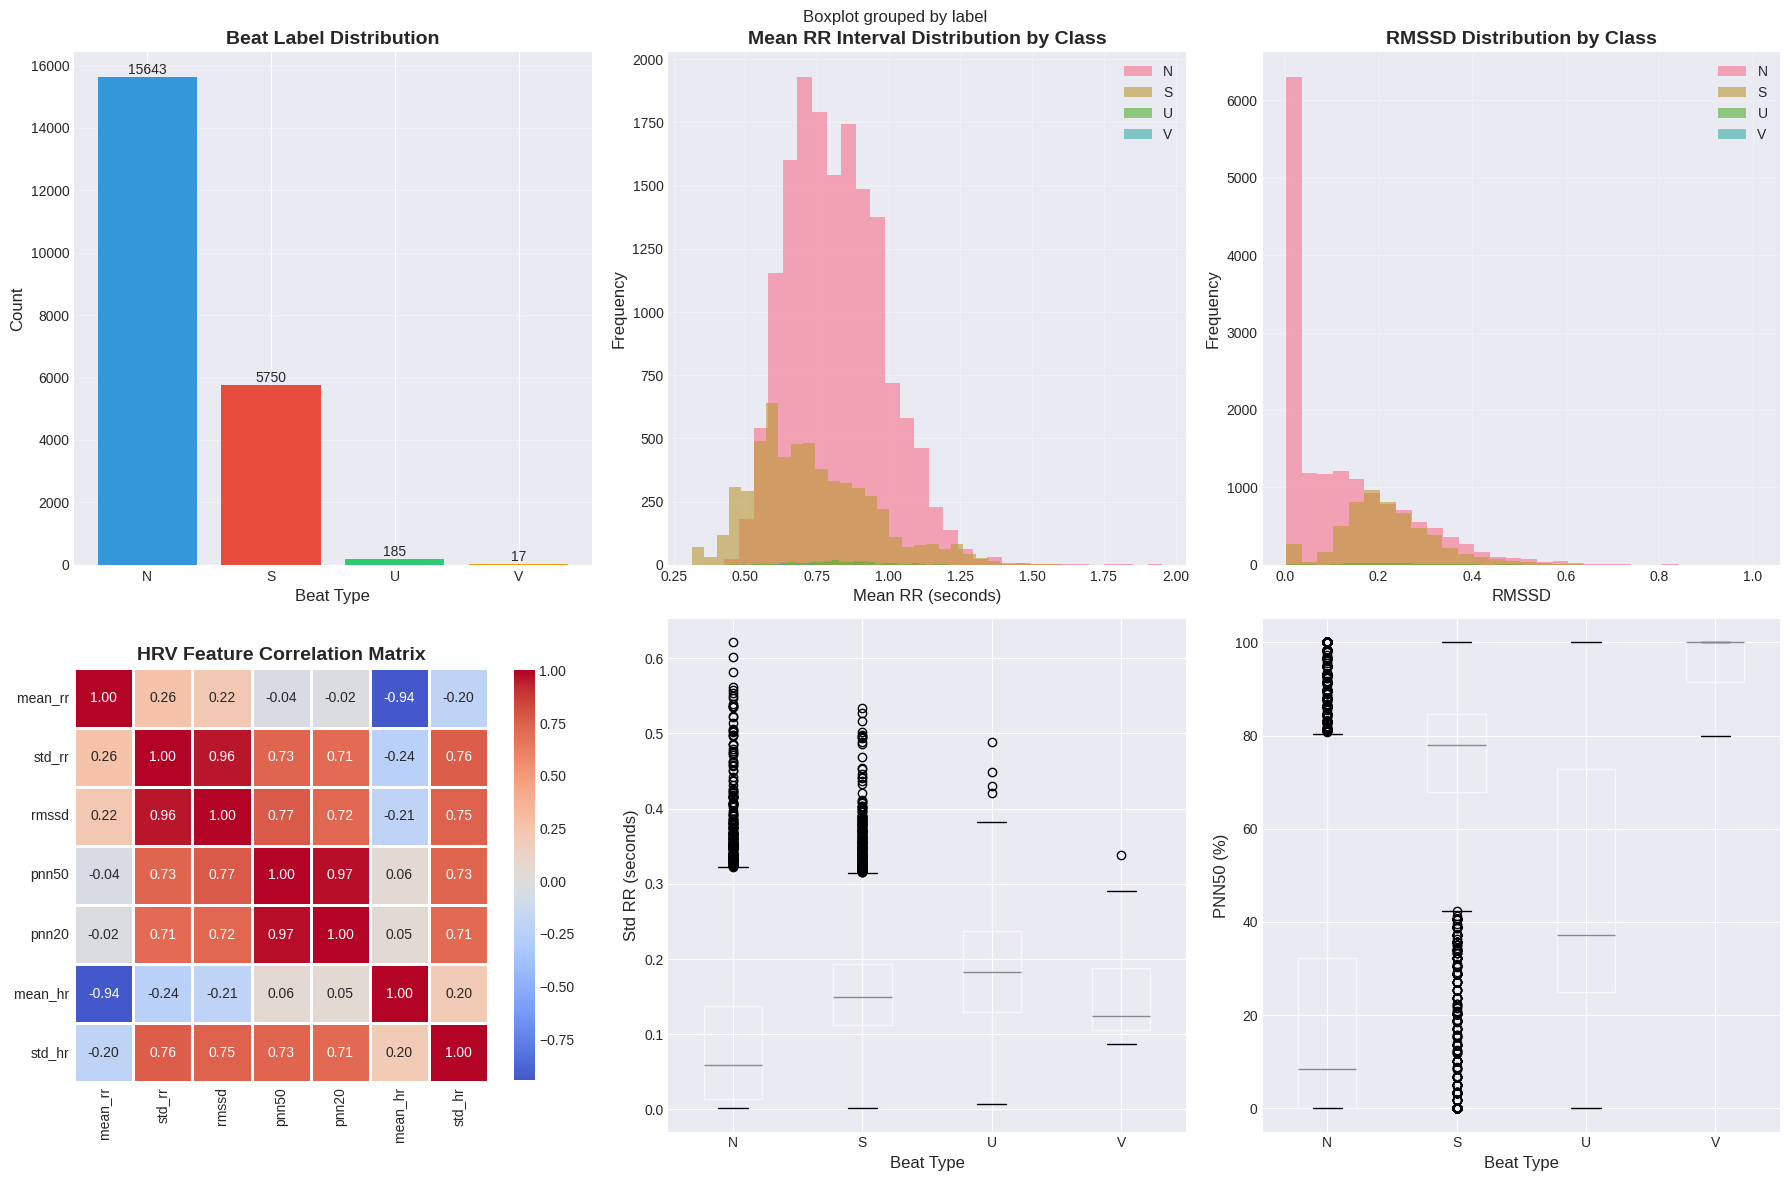


📊 Beat Classification Input Summary:
   Total windows: 21595
   Number of HRV features: 10
   Feature columns: ['mean_rr', 'std_rr', 'rmssd', 'pnn50', 'pnn20', 'min_rr', 'max_rr', 'range_rr', 'mean_hr', 'std_hr']


In [13]:
# Visualize beat classification input features (HRV features per window)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

hrv_cols = [col for col in beat_features_df.columns if col not in ['window_idx', 'label']]

# 1. Label distribution
label_counts = beat_features_df['label'].value_counts()
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12'][:len(label_counts)]
axes[0, 0].bar(label_counts.index, label_counts.values, color=colors)
axes[0, 0].set_title('Beat Label Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Beat Type', fontsize=12)
axes[0, 0].set_ylabel('Count', fontsize=12)
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(label_counts.values):
    axes[0, 0].text(i, v, str(v), ha='center', va='bottom', fontsize=10)

# 2. Feature distributions by class (mean_rr)
for label in sorted(beat_features_df['label'].unique()):
    data = beat_features_df[beat_features_df['label'] == label]['mean_rr']
    axes[0, 1].hist(data, alpha=0.6, label=label, bins=30)
axes[0, 1].set_title('Mean RR Interval Distribution by Class', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Mean RR (seconds)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature distributions by class (rmssd)
for label in sorted(beat_features_df['label'].unique()):
    data = beat_features_df[beat_features_df['label'] == label]['rmssd']
    axes[0, 2].hist(data, alpha=0.6, label=label, bins=30)
axes[0, 2].set_title('RMSSD Distribution by Class', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('RMSSD', fontsize=12)
axes[0, 2].set_ylabel('Frequency', fontsize=12)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Feature correlation heatmap
corr_features = ['mean_rr', 'std_rr', 'rmssd', 'pnn50', 'pnn20', 'mean_hr', 'std_hr']
corr_data = beat_features_df[corr_features].corr()
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[1, 0],
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
axes[1, 0].set_title('HRV Feature Correlation Matrix', fontsize=14, fontweight='bold')

# 5. Box plot: std_rr by class
beat_features_df.boxplot(column='std_rr', by='label', ax=axes[1, 1])
axes[1, 1].set_title('RR Interval Std Dev by Class', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Beat Type', fontsize=12)
axes[1, 1].set_ylabel('Std RR (seconds)', fontsize=12)
axes[1, 1].set_title('')
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=0)

# 6. Box plot: pnn50 by class
beat_features_df.boxplot(column='pnn50', by='label', ax=axes[1, 2])
axes[1, 2].set_title('PNN50 by Class', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Beat Type', fontsize=12)
axes[1, 2].set_ylabel('PNN50 (%)', fontsize=12)
axes[1, 2].set_title('')
plt.setp(axes[1, 2].xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.show()

print("\n📊 Beat Classification Input Summary:")
print(f"   Total windows: {len(beat_features_df)}")
print(f"   Number of HRV features: {len(hrv_cols)}")
print(f"   Feature columns: {hrv_cols}")


## Section 5: Beat Classification - Model Output Visualization


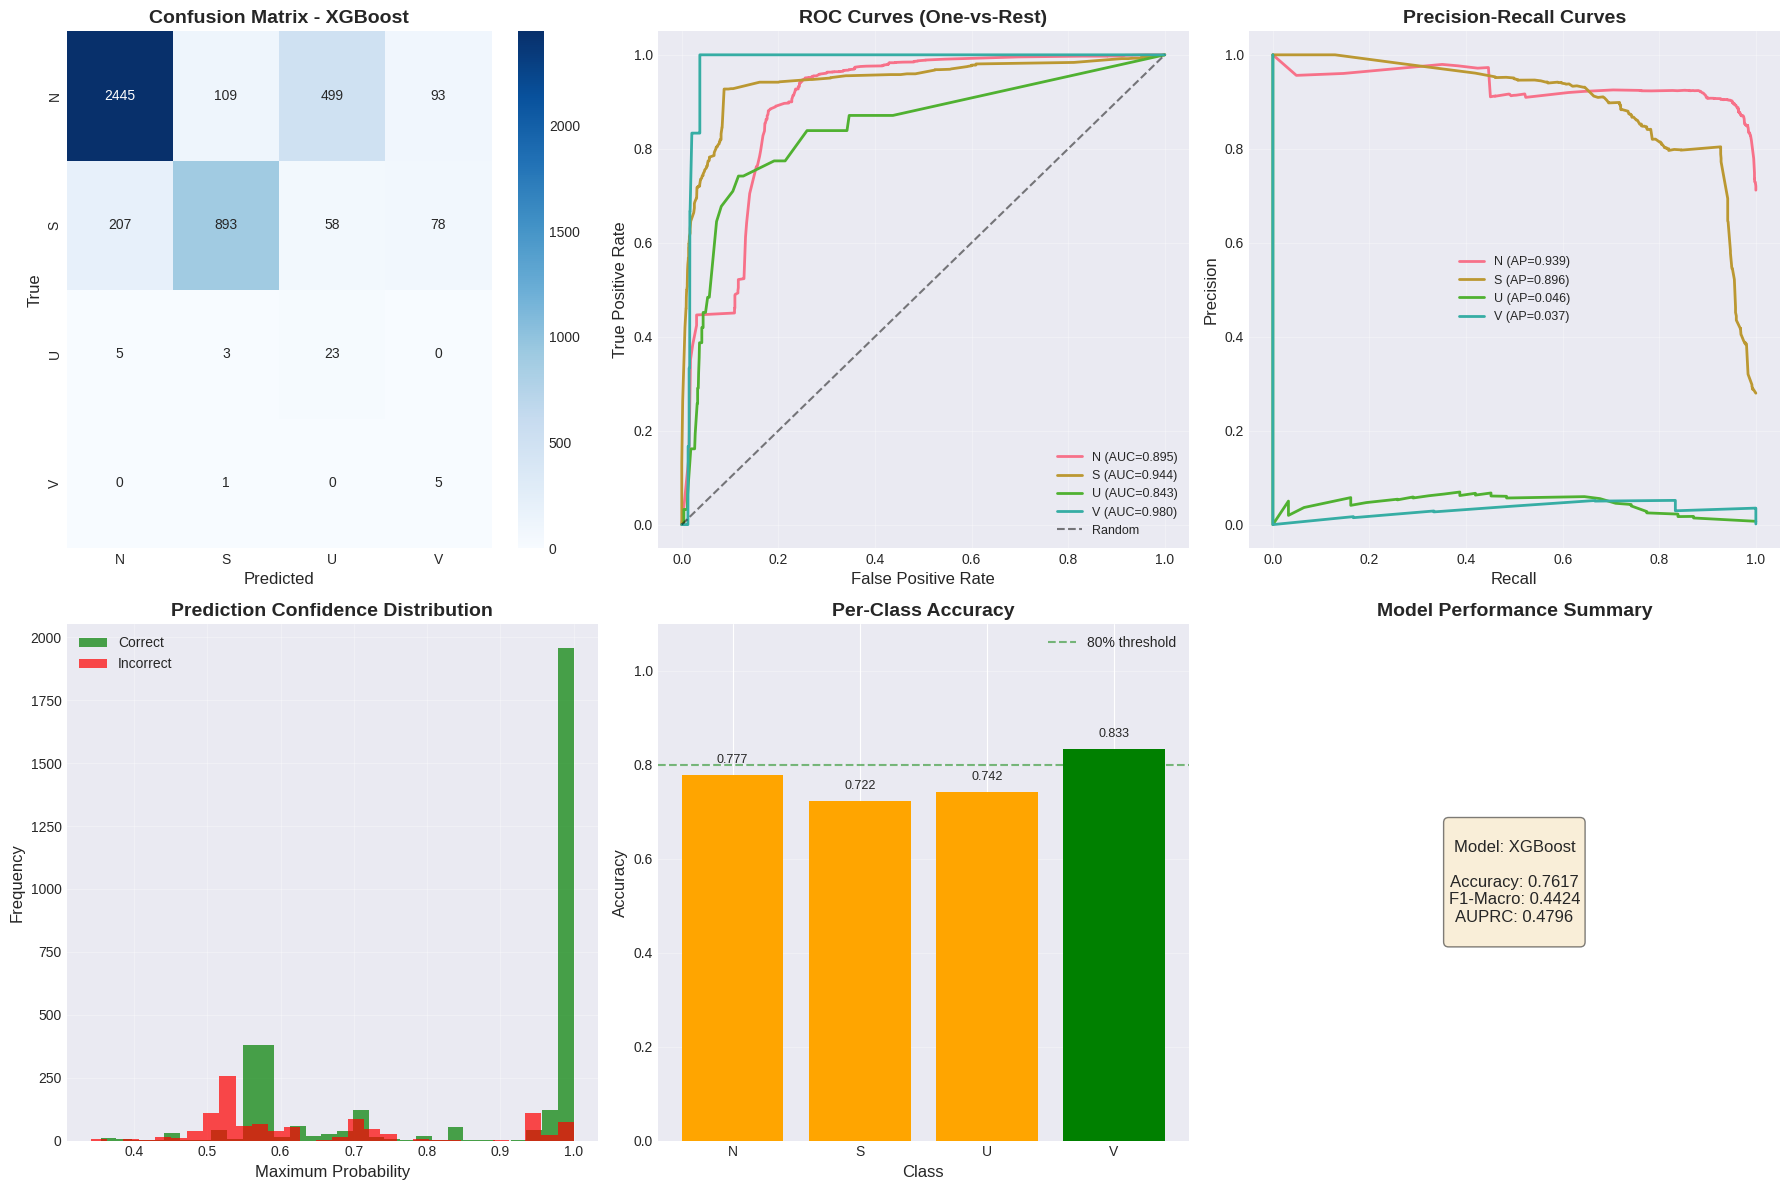


✅ Beat classification output visualizations complete!


In [14]:
# Visualize beat classification outputs
if beat_ml_predictions:
    test_true = beat_ml_predictions['test_true_str']
    test_pred = beat_ml_predictions['test_pred_str']
    test_proba = beat_ml_predictions['test_proba']
    label_encoder = beat_ml_predictions['label_encoder']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(test_true, test_pred, labels=label_encoder.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    axes[0, 0].set_title(f'Confusion Matrix - {beat_ml_predictions.get("model_name", "ML Model")}', 
                        fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Predicted', fontsize=12)
    axes[0, 0].set_ylabel('True', fontsize=12)
    
    # 2. ROC Curves (One-vs-Rest)
    y_true_binary = label_binarize(test_true, classes=label_encoder.classes_)
    for i, class_name in enumerate(label_encoder.classes_):
        fpr, tpr, _ = roc_curve(y_true_binary[:, i], test_proba[:, i])
        auc_score = roc_auc_score(y_true_binary[:, i], test_proba[:, i])
        axes[0, 1].plot(fpr, tpr, label=f'{class_name} (AUC={auc_score:.3f})', linewidth=2)
    axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
    axes[0, 1].set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
    axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
    axes[0, 1].legend(fontsize=9)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Precision-Recall Curves
    for i, class_name in enumerate(label_encoder.classes_):
        precision, recall, _ = precision_recall_curve(y_true_binary[:, i], test_proba[:, i])
        ap = average_precision_score(y_true_binary[:, i], test_proba[:, i])
        axes[0, 2].plot(recall, precision, label=f'{class_name} (AP={ap:.3f})', linewidth=2)
    axes[0, 2].set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Recall', fontsize=12)
    axes[0, 2].set_ylabel('Precision', fontsize=12)
    axes[0, 2].legend(fontsize=9)
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Prediction confidence distribution
    max_proba = np.max(test_proba, axis=1)
    correct_mask = np.array(test_true) == np.array(test_pred)
    axes[1, 0].hist(max_proba[correct_mask], bins=30, alpha=0.7, label='Correct', color='green')
    axes[1, 0].hist(max_proba[~correct_mask], bins=30, alpha=0.7, label='Incorrect', color='red')
    axes[1, 0].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Maximum Probability', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Per-class accuracy
    class_acc = []
    for class_name in label_encoder.classes_:
        mask = np.array(test_true) == class_name
        if mask.sum() > 0:
            acc = (np.array(test_pred)[mask] == class_name).mean()
            class_acc.append(acc)
        else:
            class_acc.append(0)
    
    axes[1, 1].bar(label_encoder.classes_, class_acc, 
                  color=['green' if a > 0.8 else 'orange' if a > 0.6 else 'red' for a in class_acc])
    axes[1, 1].axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='80% threshold')
    axes[1, 1].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Class', fontsize=12)
    axes[1, 1].set_ylabel('Accuracy', fontsize=12)
    axes[1, 1].set_ylim([0, 1.1])
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)
    for i, (class_name, acc) in enumerate(zip(label_encoder.classes_, class_acc)):
        axes[1, 1].text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 6. Metrics summary
    metrics = beat_ml_predictions.get('metrics', {})
    metrics_text = f"\nModel: {beat_ml_predictions.get('model_name', 'Unknown')}\n\n"
    metrics_text += f"Accuracy: {metrics.get('accuracy', 0):.4f}\n"
    metrics_text += f"F1-Macro: {metrics.get('f1_macro', 0):.4f}\n"
    if 'auroc_macro' in metrics:
        metrics_text += f"AUROC: {metrics.get('auroc_macro', 0):.4f}\n"
    if 'auprc_macro' in metrics:
        metrics_text += f"AUPRC: {metrics.get('auprc_macro', 0):.4f}\n"
    
    axes[1, 2].text(0.5, 0.5, metrics_text, ha='center', va='center', fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1, 2].set_xlim([0, 1])
    axes[1, 2].set_ylim([0, 1])
    axes[1, 2].axis('off')
    axes[1, 2].set_title('Model Performance Summary', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Beat classification output visualizations complete!")
else:
    print("⚠️  Beat ML predictions not loaded. Please run trad_ml.ipynb first.")


## Section 6: Beat Classification - Sample Predictions with Features


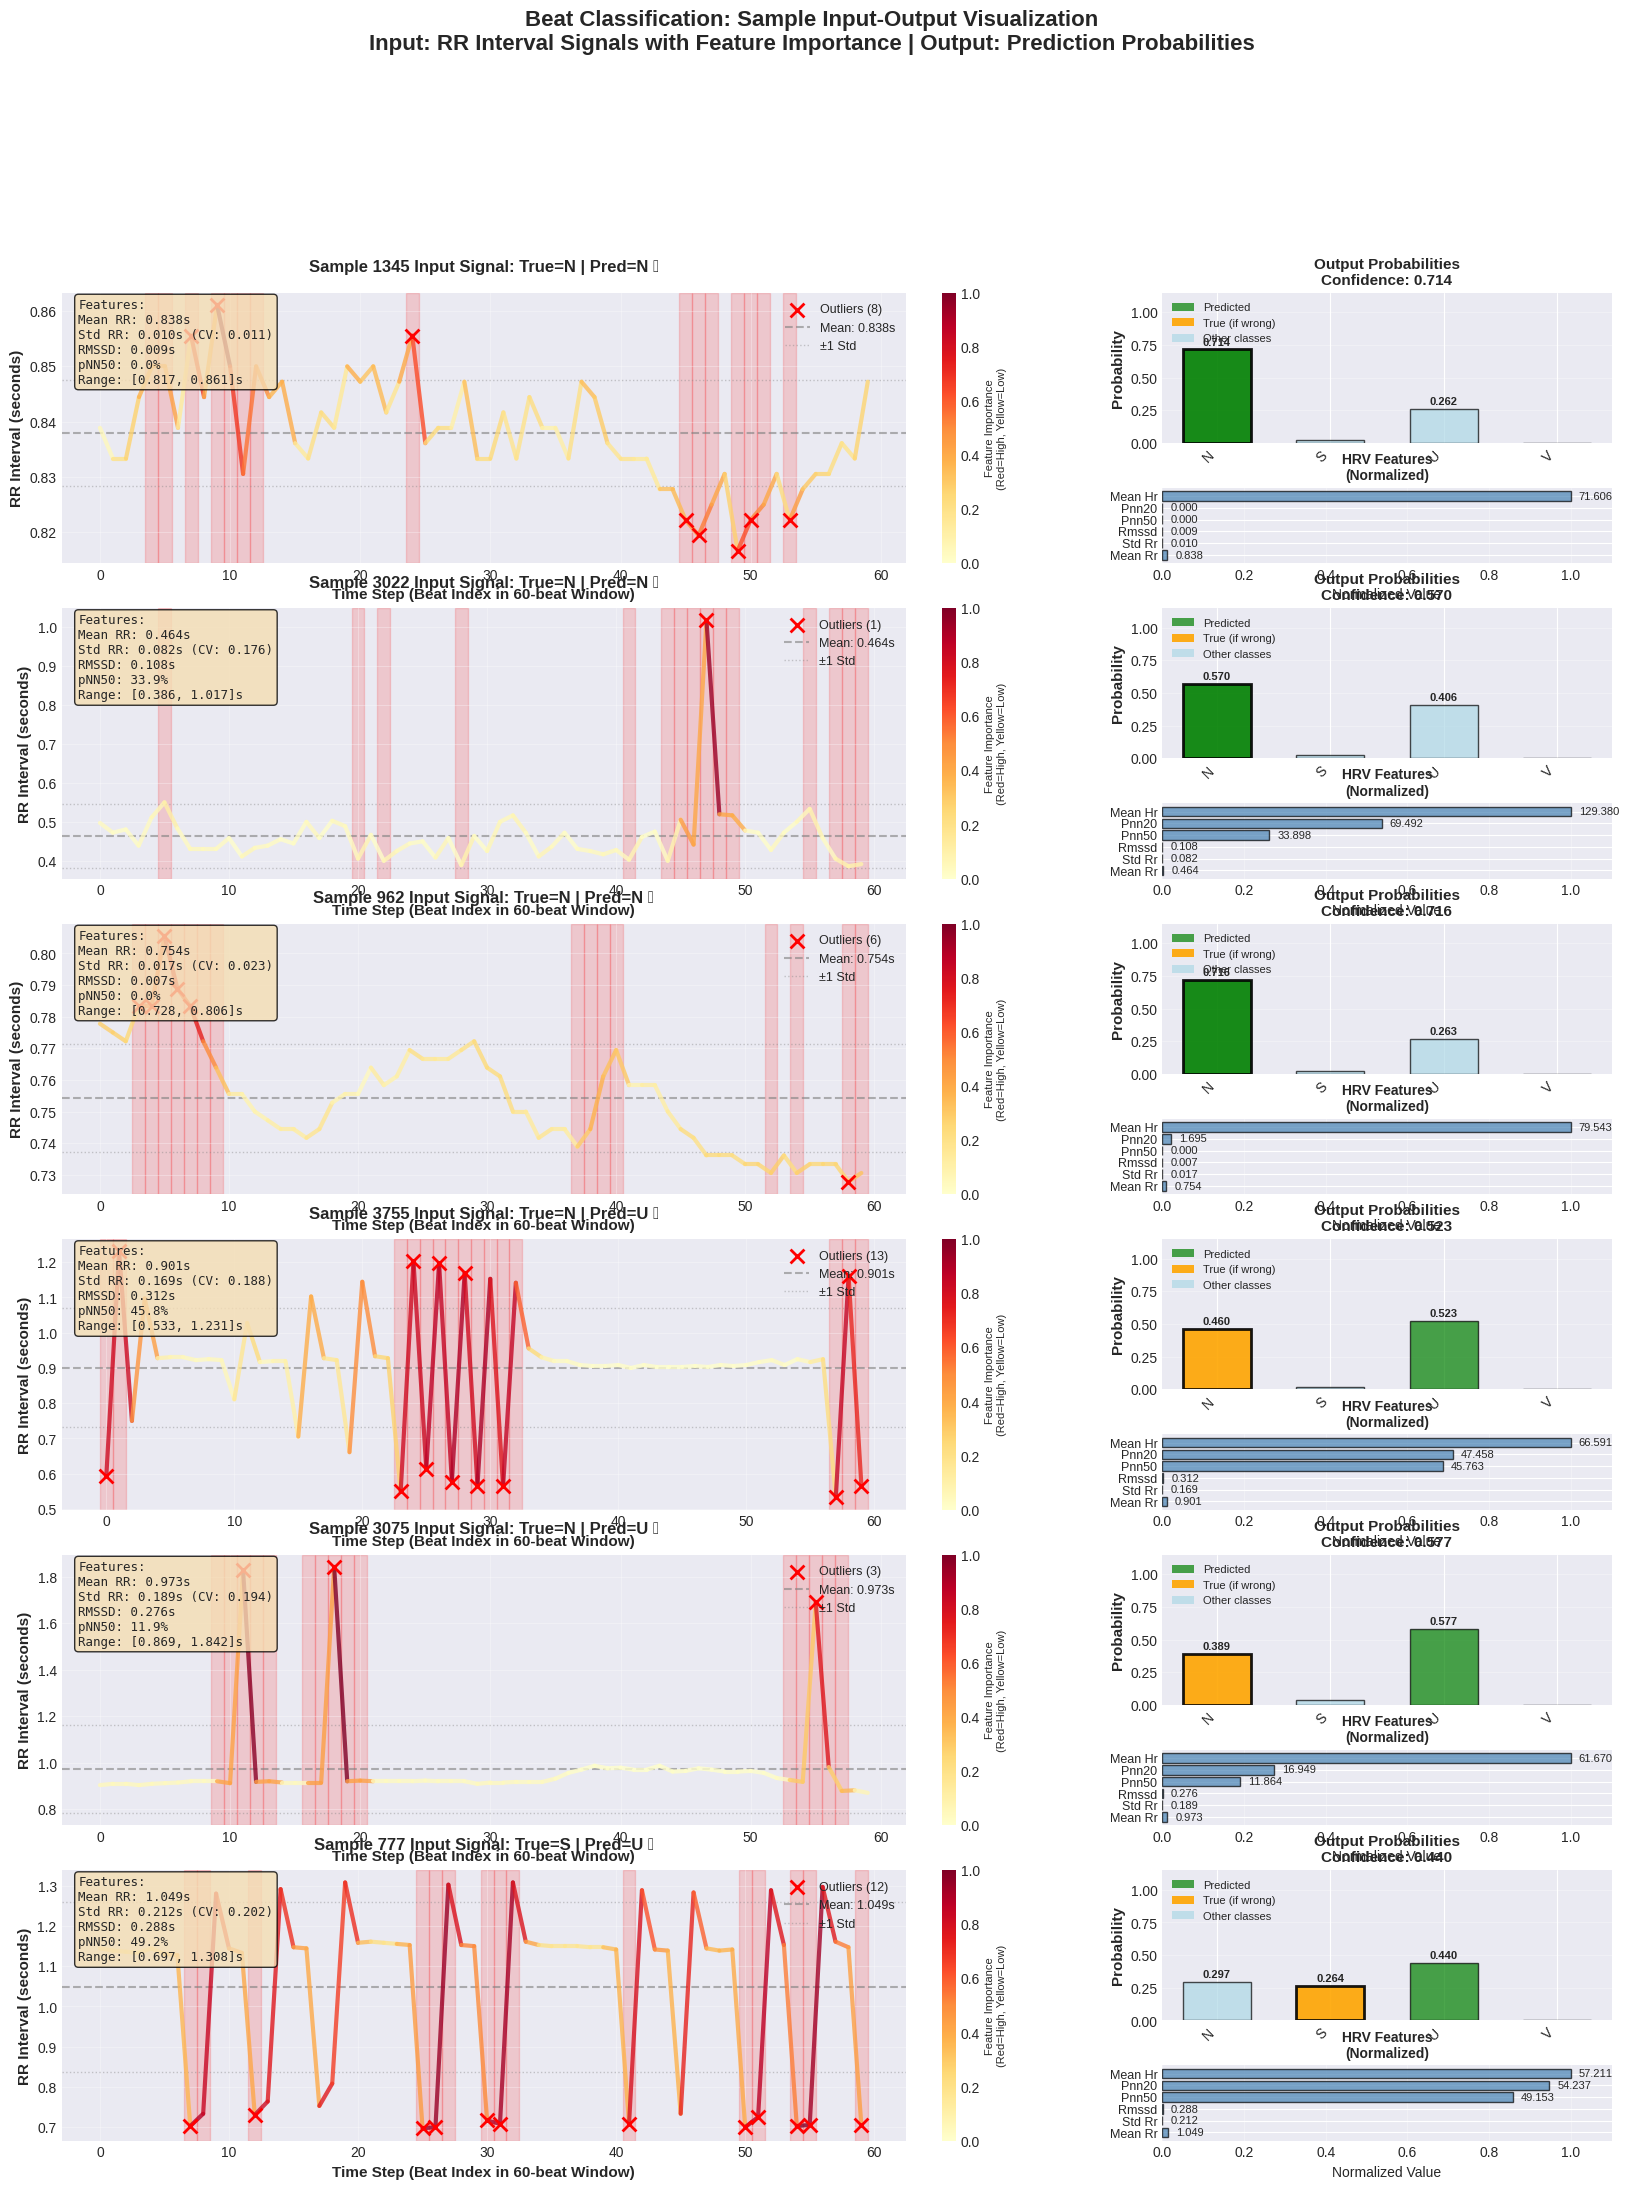


✅ Displayed 6 sample predictions
   Correct predictions: 3
   Incorrect predictions: 3

📊 Feature Importance Explanation:
   • Color-coding in signal:
     - Red/Yellow: High local variance (important for RMSSD, pNN50)
     - Outliers (red X): Extreme values (important for min/max/range features)
     - Shaded regions: Top 25% most variable segments
   • These regions directly contribute to HRV feature values used by ML models


In [15]:
# Visualize sample predictions: Input as RR interval signal + Output probabilities
# Emphasize which time steps/features affect the prediction
if beat_ml_predictions:
    test_true = np.array(beat_ml_predictions['test_true_str'])
    test_pred = np.array(beat_ml_predictions['test_pred_str'])
    test_proba = beat_ml_predictions['test_proba']
    label_encoder = beat_ml_predictions['label_encoder']
    
    # Select samples (correct and incorrect)
    np.random.seed(42)
    n_samples = 6
    
    correct_indices = np.where(test_true == test_pred)[0]
    incorrect_indices = np.where(test_true != test_pred)[0]
    
    selected_indices = []
    if len(correct_indices) > 0:
        selected_indices.extend(np.random.choice(correct_indices, min(3, len(correct_indices)), replace=False).tolist())
    if len(incorrect_indices) > 0:
        selected_indices.extend(np.random.choice(incorrect_indices, min(3, len(incorrect_indices)), replace=False).tolist())
    selected_indices = selected_indices[:n_samples]
    
    # Get corresponding RR interval sequences
    # Map test indices to window indices (assuming test set comes from beat_sequences)
    # We'll use the sequences we created earlier in Cell 6
    
    # Create visualization: 2 rows per sample (signal on top, output below)
    fig = plt.figure(figsize=(20, n_samples * 4))
    gs = fig.add_gridspec(n_samples * 2, 2, hspace=0.4, wspace=0.3, 
                          height_ratios=[2, 1] * n_samples, width_ratios=[2, 1])
    
    for idx, sample_idx in enumerate(selected_indices):
        row = idx * 2
        
        true_label = test_true[sample_idx]
        pred_label = test_pred[sample_idx]
        proba = test_proba[sample_idx]
        correct = (true_label == pred_label)
        status = "✅" if correct else "❌"
        
        # LEFT COLUMN: Input Signal (RR Intervals) with Feature Importance Highlighting
        ax_signal = fig.add_subplot(gs[row:row+2, 0])
        
        # Get the corresponding RR interval sequence
        # Note: sample_idx refers to test set index, need to map to original sequence index
        # For now, try to get from beat_sequences if available
        try:
            if 'beat_sequences' in locals() and sample_idx < len(beat_sequences):
                sequence = beat_sequences[sample_idx]
            else:
                # Try to reconstruct from features (approximate)
                if sample_idx < len(beat_features_df):
                    sample_features = beat_features_df.iloc[sample_idx]
                    # Create a representative sequence based on features
                    mean_rr = sample_features.get('mean_rr', 0.8)
                    std_rr = sample_features.get('std_rr', 0.1)
                    # Generate synthetic sequence for visualization
                    np.random.seed(sample_idx)
                    sequence = np.random.normal(mean_rr, std_rr, 60)
                    sequence = np.clip(sequence, 0.3, 3.0)  # Reasonable RR bounds
                else:
                    raise ValueError("Cannot get sequence")
            
            time_steps = np.arange(len(sequence))
            
            # Calculate feature importance indicators
            # 1. Local variance (important for RMSSD, pNN50)
            window_size = 5
            local_variance = np.array([
                np.var(sequence[max(0, i-window_size//2):min(len(sequence), i+window_size//2+1)]) 
                for i in range(len(sequence))
            ])
            
            # 2. Outlier detection (important for min_rr, max_rr, range_rr)
            mean_rr = np.mean(sequence)
            std_rr = np.std(sequence)
            z_scores = np.abs((sequence - mean_rr) / std_rr) if std_rr > 0 else np.zeros(len(sequence))
            outliers = z_scores > 1.5
            
            # 3. Deviation from mean (important for std_rr, mean_rr)
            deviations = np.abs(sequence - mean_rr)
            
            # Combine importance scores (normalize)
            importance_var = local_variance / np.max(local_variance) if np.max(local_variance) > 0 else local_variance
            importance_outlier = z_scores / np.max(z_scores) if np.max(z_scores) > 0 else z_scores
            importance_dev = deviations / np.max(deviations) if np.max(deviations) > 0 else deviations
            
            # Weighted combination (variance and outliers are most important for HRV features)
            importance = 0.4 * importance_var + 0.4 * importance_outlier + 0.2 * importance_dev
            importance = np.clip(importance, 0, 1)
            
            # Color-code signal by importance
            colors = plt.cm.YlOrRd(importance)
            
            # Plot signal with color gradient
            for i in range(len(sequence) - 1):
                ax_signal.plot([time_steps[i], time_steps[i+1]], 
                             [sequence[i], sequence[i+1]], 
                             color=colors[i], linewidth=3, alpha=0.8, zorder=2)
            
            # Add scatter points for outlier emphasis
            outlier_indices = np.where(outliers)[0]
            if len(outlier_indices) > 0:
                ax_signal.scatter(time_steps[outlier_indices], sequence[outlier_indices],
                                color='red', s=100, marker='x', linewidths=2,
                                label=f'Outliers ({len(outlier_indices)})', zorder=3)
            
            # Highlight top 25% most important regions (shaded)
            top_important = importance > np.percentile(importance, 75)
            for i in np.where(top_important)[0]:
                ax_signal.axvspan(i-0.5, i+0.5, alpha=0.15, color='red', zorder=0)
            
            # Add reference lines
            ax_signal.axhline(y=mean_rr, color='gray', linestyle='--', linewidth=1.5, 
                            alpha=0.6, label=f'Mean: {mean_rr:.3f}s', zorder=1)
            ax_signal.axhline(y=mean_rr + std_rr, color='gray', linestyle=':', linewidth=1, 
                            alpha=0.4, label=f'±1 Std', zorder=1)
            ax_signal.axhline(y=mean_rr - std_rr, color='gray', linestyle=':', linewidth=1, 
                            alpha=0.4, zorder=1)
            
            # Calculate and display key HRV features
            if sample_idx < len(beat_features_df):
                sample_features = beat_features_df.iloc[sample_idx]
                rmssd = sample_features.get('rmssd', 0)
                pnn50 = sample_features.get('pnn50', 0)
                cv = std_rr / mean_rr if mean_rr > 0 else 0
            else:
                # Calculate from sequence
                diff_rr = np.diff(sequence)
                rmssd = np.sqrt(np.mean(diff_rr ** 2))
                pnn50 = np.sum(np.abs(diff_rr) > 0.05) / len(diff_rr) * 100 if len(diff_rr) > 0 else 0
                cv = std_rr / mean_rr if mean_rr > 0 else 0
            
            # Feature summary text
            stats_text = f'Features:\n'
            stats_text += f'Mean RR: {mean_rr:.3f}s\n'
            stats_text += f'Std RR: {std_rr:.3f}s (CV: {cv:.3f})\n'
            stats_text += f'RMSSD: {rmssd:.3f}s\n'
            stats_text += f'pNN50: {pnn50:.1f}%\n'
            stats_text += f'Range: [{np.min(sequence):.3f}, {np.max(sequence):.3f}]s'
            
            ax_signal.text(0.02, 0.98, stats_text, transform=ax_signal.transAxes,
                          fontsize=9, verticalalignment='top', family='monospace',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            ax_signal.set_xlabel('Time Step (Beat Index in 60-beat Window)', fontsize=11, fontweight='bold')
            ax_signal.set_ylabel('RR Interval (seconds)', fontsize=11, fontweight='bold')
            ax_signal.set_title(f'Sample {sample_idx} Input Signal: True={true_label} | Pred={pred_label} {status}', 
                              fontsize=12, fontweight='bold', pad=15)
            ax_signal.grid(True, alpha=0.3, zorder=0)
            ax_signal.legend(loc='upper right', fontsize=9, framealpha=0.9)
            
            # Add colorbar for importance
            sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=0, vmax=1))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax_signal, fraction=0.02, pad=0.04)
            cbar.set_label('Feature Importance\n(Red=High, Yellow=Low)', fontsize=8)
            
        except Exception as e:
            ax_signal.text(0.5, 0.5, f'Sequence not available\nfor sample {sample_idx}\n({str(e)[:50]})', 
                          ha='center', va='center', fontsize=10,
                          bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
            ax_signal.set_xlim([0, 1])
            ax_signal.set_ylim([0, 1])
            ax_signal.axis('off')
        
        # RIGHT COLUMN: Output Probabilities (aligned with signal)
        ax_prob = fig.add_subplot(gs[row, 1])
        
        # Bar chart for probabilities
        bars = ax_prob.bar(range(len(label_encoder.classes_)), proba, 
                      color=['green' if c == pred_label else 'lightblue' 
                            for c in label_encoder.classes_],
                      alpha=0.7, edgecolor='black', width=0.6)
        
        # Highlight true class
        true_idx = np.where(label_encoder.classes_ == true_label)[0]
        if len(true_idx) > 0:
            bars[true_idx[0]].set_color('orange' if not correct else 'green')
            bars[true_idx[0]].set_alpha(0.9)
            bars[true_idx[0]].set_edgecolor('black')
            bars[true_idx[0]].set_linewidth(2)
        
        ax_prob.set_xticks(range(len(label_encoder.classes_)))
        ax_prob.set_xticklabels(label_encoder.classes_, rotation=45, ha='right', fontsize=10)
        ax_prob.set_ylabel('Probability', fontsize=11, fontweight='bold')
        ax_prob.set_ylim([0, 1.15])
        ax_prob.grid(axis='y', alpha=0.3)
        
        # Title
        pred_conf = proba[np.where(label_encoder.classes_ == pred_label)[0][0]] if len(np.where(label_encoder.classes_ == pred_label)[0]) > 0 else 0
        ax_prob.set_title(f'Output Probabilities\nConfidence: {pred_conf:.3f}', 
                         fontsize=11, fontweight='bold')
        
        # Add probability values on bars
        for i, (bar, prob) in enumerate(zip(bars, proba)):
            if prob > 0.05:
                ax_prob.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                       f'{prob:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        # Add legend for bar colors
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='green', alpha=0.7, label='Predicted'),
            Patch(facecolor='orange', alpha=0.9, label='True (if wrong)'),
            Patch(facecolor='lightblue', alpha=0.7, label='Other classes')
        ]
        ax_prob.legend(handles=legend_elements, loc='upper left', fontsize=8)
        
        # Bottom right: Feature importance bar chart
        ax_feat = fig.add_subplot(gs[row+1, 1])
        
        # Get key HRV features
        if sample_idx < len(beat_features_df):
            sample_features = beat_features_df.iloc[sample_idx]
            key_features = ['mean_rr', 'std_rr', 'rmssd', 'pnn50', 'pnn20', 'mean_hr']
            feature_values = []
            feature_names = []
            for f in key_features:
                if f in sample_features:
                    feature_values.append(sample_features[f])
                    feature_names.append(f.replace('_', ' ').title())
        else:
            # Use calculated values
            feature_values = [mean_rr, std_rr, rmssd, pnn50, 0, 60/mean_rr if mean_rr > 0 else 0]
            feature_names = ['Mean RR', 'Std RR', 'RMSSD', 'PNN50', 'PNN20', 'Mean HR']
        
        # Normalize for visualization (relative importance)
        if len(feature_values) > 0:
            # Normalize to [0, 1] for visual comparison
            feat_array = np.array(feature_values)
            feat_normalized = (feat_array - np.min(feat_array)) / (np.max(feat_array) - np.min(feat_array)) if np.max(feat_array) != np.min(feat_array) else np.ones(len(feat_array))
            
            bars_feat = ax_feat.barh(range(len(feature_names)), feat_normalized, 
                                    color='steelblue', alpha=0.7, edgecolor='black')
            ax_feat.set_yticks(range(len(feature_names)))
            ax_feat.set_yticklabels(feature_names, fontsize=9)
            ax_feat.set_xlabel('Normalized Value', fontsize=10)
            ax_feat.set_title('HRV Features\n(Normalized)', fontsize=10, fontweight='bold')
            ax_feat.set_xlim([0, 1.1])
            ax_feat.grid(axis='x', alpha=0.3)
            
            # Add actual values as text
            for i, (bar, val) in enumerate(zip(bars_feat, feature_values)):
                ax_feat.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                           f'{val:.3f}', va='center', fontsize=8)
        else:
            ax_feat.text(0.5, 0.5, 'Features\nunavailable', ha='center', va='center')
            ax_feat.set_xlim([0, 1])
            ax_feat.set_ylim([0, 1])
    
    plt.suptitle('Beat Classification: Sample Input-Output Visualization\n' + 
                 'Input: RR Interval Signals with Feature Importance | Output: Prediction Probabilities', 
                 fontsize=16, fontweight='bold', y=0.998)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Displayed {len(selected_indices)} sample predictions")
    print(f"   Correct predictions: {sum([test_true[i] == test_pred[i] for i in selected_indices])}")
    print(f"   Incorrect predictions: {sum([test_true[i] != test_pred[i] for i in selected_indices])}")
    print("\n📊 Feature Importance Explanation:")
    print("   • Color-coding in signal:")
    print("     - Red/Yellow: High local variance (important for RMSSD, pNN50)")
    print("     - Outliers (red X): Extreme values (important for min/max/range features)")
    print("     - Shaded regions: Top 25% most variable segments")
    print("   • These regions directly contribute to HRV feature values used by ML models")
else:
    print("⚠️  Beat ML predictions not loaded. Please run trad_ml.ipynb first.")


## Section 7: Rhythm Classification - Sample Input-Output Visualization


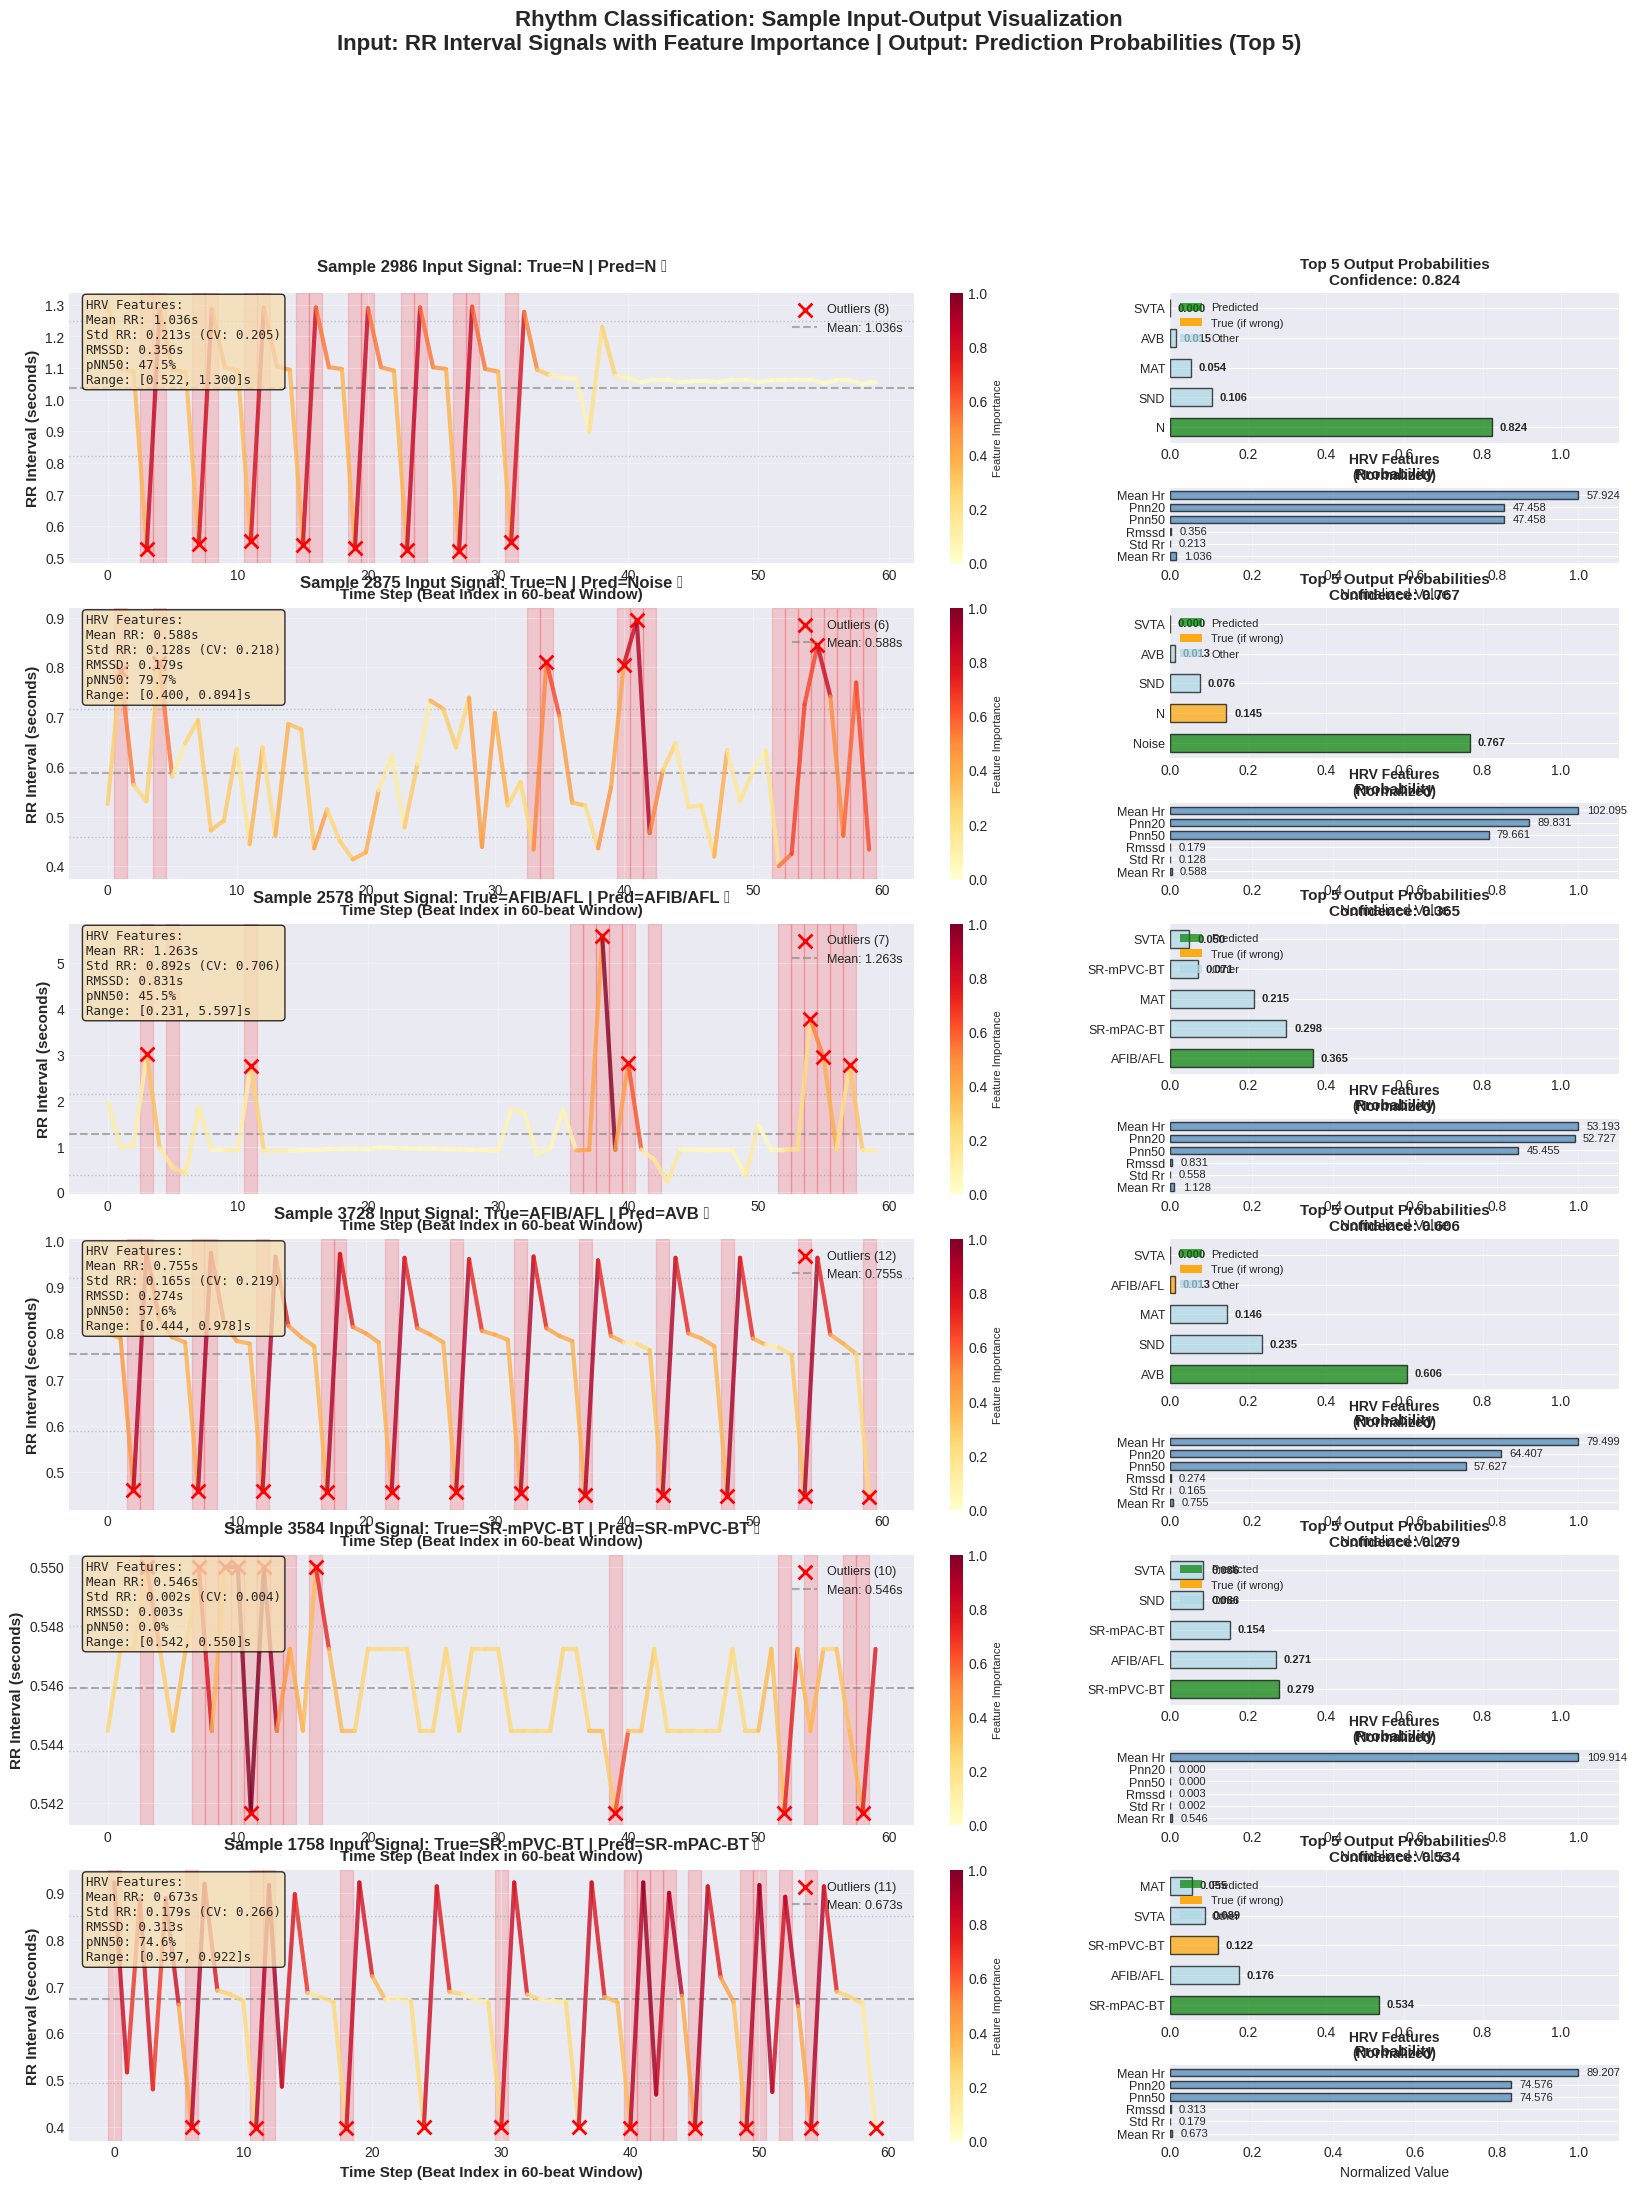


✅ Displayed 6 sample predictions
   Correct predictions: 3
   Incorrect predictions: 3

📊 Feature Importance Explanation:
   • Color-coding shows which time steps contribute most to HRV features
   • Red regions: High variance/outliers (affect RMSSD, pNN50, std_rr)
   • Outliers (X markers): Extreme values (affect min_rr, max_rr, range_rr)
   • These features are extracted and used by ML models for classification


In [16]:
# Visualize rhythm classification sample predictions: Input as RR interval signal + Output probabilities
if rhythm_ml_predictions:
    test_true = np.array(rhythm_ml_predictions['test_true_str'])
    test_pred = np.array(rhythm_ml_predictions['test_pred_str'])
    test_proba = rhythm_ml_predictions['test_proba']
    label_encoder = rhythm_ml_predictions['label_encoder']
    
    # Select samples (focus on top classes)
    np.random.seed(42)
    n_samples = 6
    
    # Get diverse samples from top classes
    top_classes = pd.Series(test_true).value_counts().head(4).index.tolist()
    selected_indices = []
    
    for class_name in top_classes[:3]:  # Top 3 classes
        class_indices = np.where(test_true == class_name)[0]
        if len(class_indices) > 0:
            # Get both correct and incorrect if available
            correct_class = class_indices[np.where(test_pred[class_indices] == class_name)[0]]
            incorrect_class = class_indices[np.where(test_pred[class_indices] != class_name)[0]]
            
            if len(correct_class) > 0:
                selected_indices.extend(np.random.choice(correct_class, min(1, len(correct_class)), replace=False).tolist())
            if len(incorrect_class) > 0 and len(selected_indices) < n_samples:
                selected_indices.extend(np.random.choice(incorrect_class, min(1, len(incorrect_class)), replace=False).tolist())
    
    selected_indices = selected_indices[:n_samples]
    
    # Create visualization: 2 rows per sample (signal on top, output below)
    fig = plt.figure(figsize=(20, n_samples * 4))
    gs = fig.add_gridspec(n_samples * 2, 2, hspace=0.4, wspace=0.3, 
                          height_ratios=[2, 1] * n_samples, width_ratios=[2, 1])
    
    for idx, sample_idx in enumerate(selected_indices):
        row = idx * 2
        
        true_label = test_true[sample_idx]
        pred_label = test_pred[sample_idx]
        proba = test_proba[sample_idx]
        correct = (true_label == pred_label)
        status = "✅" if correct else "❌"
        
        # LEFT COLUMN: Input Signal (RR Intervals) with Feature Importance Highlighting
        ax_signal = fig.add_subplot(gs[row:row+2, 0])
        
        # Get the corresponding RR interval sequence
        try:
            if 'rhythm_sequences' in locals() and sample_idx < len(rhythm_sequences):
                sequence = rhythm_sequences[sample_idx]
            else:
                # Try to reconstruct from features
                if sample_idx < len(rhythm_features_df):
                    sample_features = rhythm_features_df.iloc[sample_idx]
                    mean_rr = sample_features.get('mean_rr', 0.8)
                    std_rr = sample_features.get('std_rr', 0.1)
                    np.random.seed(sample_idx)
                    sequence = np.random.normal(mean_rr, std_rr, 60)
                    sequence = np.clip(sequence, 0.3, 3.0)
                else:
                    raise ValueError("Cannot get sequence")
            
            time_steps = np.arange(len(sequence))
            
            # Calculate feature importance indicators
            window_size = 5
            local_variance = np.array([
                np.var(sequence[max(0, i-window_size//2):min(len(sequence), i+window_size//2+1)]) 
                for i in range(len(sequence))
            ])
            
            mean_rr = np.mean(sequence)
            std_rr = np.std(sequence)
            z_scores = np.abs((sequence - mean_rr) / std_rr) if std_rr > 0 else np.zeros(len(sequence))
            outliers = z_scores > 1.5
            deviations = np.abs(sequence - mean_rr)
            
            # Combine importance scores
            importance_var = local_variance / np.max(local_variance) if np.max(local_variance) > 0 else local_variance
            importance_outlier = z_scores / np.max(z_scores) if np.max(z_scores) > 0 else z_scores
            importance_dev = deviations / np.max(deviations) if np.max(deviations) > 0 else deviations
            
            importance = 0.4 * importance_var + 0.4 * importance_outlier + 0.2 * importance_dev
            importance = np.clip(importance, 0, 1)
            
            # Color-code signal by importance
            colors = plt.cm.YlOrRd(importance)
            
            # Plot signal
            for i in range(len(sequence) - 1):
                ax_signal.plot([time_steps[i], time_steps[i+1]], 
                             [sequence[i], sequence[i+1]], 
                             color=colors[i], linewidth=3, alpha=0.8, zorder=2)
            
            # Highlight outliers
            outlier_indices = np.where(outliers)[0]
            if len(outlier_indices) > 0:
                ax_signal.scatter(time_steps[outlier_indices], sequence[outlier_indices],
                                color='red', s=100, marker='x', linewidths=2,
                                label=f'Outliers ({len(outlier_indices)})', zorder=3)
            
            # Highlight important regions
            top_important = importance > np.percentile(importance, 75)
            for i in np.where(top_important)[0]:
                ax_signal.axvspan(i-0.5, i+0.5, alpha=0.15, color='red', zorder=0)
            
            # Reference lines
            ax_signal.axhline(y=mean_rr, color='gray', linestyle='--', linewidth=1.5, 
                            alpha=0.6, label=f'Mean: {mean_rr:.3f}s', zorder=1)
            ax_signal.axhline(y=mean_rr + std_rr, color='gray', linestyle=':', linewidth=1, 
                            alpha=0.4, zorder=1)
            ax_signal.axhline(y=mean_rr - std_rr, color='gray', linestyle=':', linewidth=1, 
                            alpha=0.4, zorder=1)
            
            # Calculate HRV features
            if sample_idx < len(rhythm_features_df):
                sample_features = rhythm_features_df.iloc[sample_idx]
                rmssd = sample_features.get('rmssd', 0)
                pnn50 = sample_features.get('pnn50', 0)
            else:
                diff_rr = np.diff(sequence)
                rmssd = np.sqrt(np.mean(diff_rr ** 2))
                pnn50 = np.sum(np.abs(diff_rr) > 0.05) / len(diff_rr) * 100 if len(diff_rr) > 0 else 0
            cv = std_rr / mean_rr if mean_rr > 0 else 0
            
            # Feature summary
            stats_text = f'HRV Features:\n'
            stats_text += f'Mean RR: {mean_rr:.3f}s\n'
            stats_text += f'Std RR: {std_rr:.3f}s (CV: {cv:.3f})\n'
            stats_text += f'RMSSD: {rmssd:.3f}s\n'
            stats_text += f'pNN50: {pnn50:.1f}%\n'
            stats_text += f'Range: [{np.min(sequence):.3f}, {np.max(sequence):.3f}]s'
            
            ax_signal.text(0.02, 0.98, stats_text, transform=ax_signal.transAxes,
                          fontsize=9, verticalalignment='top', family='monospace',
                          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            ax_signal.set_xlabel('Time Step (Beat Index in 60-beat Window)', fontsize=11, fontweight='bold')
            ax_signal.set_ylabel('RR Interval (seconds)', fontsize=11, fontweight='bold')
            ax_signal.set_title(f'Sample {sample_idx} Input Signal: True={true_label} | Pred={pred_label} {status}', 
                              fontsize=12, fontweight='bold', pad=15)
            ax_signal.grid(True, alpha=0.3, zorder=0)
            ax_signal.legend(loc='upper right', fontsize=9, framealpha=0.9)
            
            # Colorbar for importance
            sm = plt.cm.ScalarMappable(cmap=plt.cm.YlOrRd, norm=plt.Normalize(vmin=0, vmax=1))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax_signal, fraction=0.02, pad=0.04)
            cbar.set_label('Feature Importance', fontsize=8)
            
        except Exception as e:
            ax_signal.text(0.5, 0.5, f'Sequence not available\nfor sample {sample_idx}', 
                          ha='center', va='center', fontsize=10,
                          bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
            ax_signal.set_xlim([0, 1])
            ax_signal.set_ylim([0, 1])
            ax_signal.axis('off')
        
        # RIGHT COLUMN: Output Probabilities (Top 5 classes + others)
        ax_prob = fig.add_subplot(gs[row, 1])
        
        # Get top 5 probabilities
        top_5_idx = np.argsort(proba)[-5:][::-1]
        top_5_proba = proba[top_5_idx]
        top_5_classes = label_encoder.classes_[top_5_idx]
        
        # Bar chart
        colors_prob = []
        for cls in top_5_classes:
            if cls == pred_label:
                colors_prob.append('green')
            elif cls == true_label:
                colors_prob.append('orange' if not correct else 'green')
            else:
                colors_prob.append('lightblue')
        
        bars = ax_prob.barh(range(len(top_5_classes)), top_5_proba, 
                      color=colors_prob, alpha=0.7, edgecolor='black', height=0.6)
        
        ax_prob.set_yticks(range(len(top_5_classes)))
        ax_prob.set_yticklabels(top_5_classes, fontsize=9)
        ax_prob.set_xlabel('Probability', fontsize=11, fontweight='bold')
        ax_prob.set_xlim([0, 1.15])
        ax_prob.grid(axis='x', alpha=0.3)
        
        pred_conf = proba[np.where(label_encoder.classes_ == pred_label)[0][0]] if len(np.where(label_encoder.classes_ == pred_label)[0]) > 0 else 0
        ax_prob.set_title(f'Top 5 Output Probabilities\nConfidence: {pred_conf:.3f}', 
                         fontsize=11, fontweight='bold')
        
        # Add probability values
        for i, (bar, prob) in enumerate(zip(bars, top_5_proba)):
            ax_prob.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                       f'{prob:.3f}', va='center', fontsize=8, fontweight='bold')
        
        # Legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='green', alpha=0.7, label='Predicted'),
            Patch(facecolor='orange', alpha=0.9, label='True (if wrong)'),
            Patch(facecolor='lightblue', alpha=0.7, label='Other')
        ]
        ax_prob.legend(handles=legend_elements, loc='upper left', fontsize=8)
        
        # Bottom right: Key HRV features
        ax_feat = fig.add_subplot(gs[row+1, 1])
        
        if sample_idx < len(rhythm_features_df):
            sample_features = rhythm_features_df.iloc[sample_idx]
            key_features = ['mean_rr', 'std_rr', 'rmssd', 'pnn50', 'pnn20', 'mean_hr']
            feature_values = []
            feature_names = []
            for f in key_features:
                if f in sample_features:
                    feature_values.append(sample_features[f])
                    feature_names.append(f.replace('_', ' ').title())
        else:
            feature_values = [mean_rr, std_rr, rmssd, pnn50, 0, 60/mean_rr if mean_rr > 0 else 0]
            feature_names = ['Mean RR', 'Std RR', 'RMSSD', 'PNN50', 'PNN20', 'Mean HR']
        
        if len(feature_values) > 0:
            feat_array = np.array(feature_values)
            feat_normalized = (feat_array - np.min(feat_array)) / (np.max(feat_array) - np.min(feat_array)) if np.max(feat_array) != np.min(feat_array) else np.ones(len(feat_array))
            
            bars_feat = ax_feat.barh(range(len(feature_names)), feat_normalized, 
                                    color='steelblue', alpha=0.7, edgecolor='black', height=0.6)
            ax_feat.set_yticks(range(len(feature_names)))
            ax_feat.set_yticklabels(feature_names, fontsize=9)
            ax_feat.set_xlabel('Normalized Value', fontsize=10)
            ax_feat.set_title('HRV Features\n(Normalized)', fontsize=10, fontweight='bold')
            ax_feat.set_xlim([0, 1.1])
            ax_feat.grid(axis='x', alpha=0.3)
            
            for i, (bar, val) in enumerate(zip(bars_feat, feature_values)):
                ax_feat.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                           f'{val:.3f}', va='center', fontsize=8)
        else:
            ax_feat.text(0.5, 0.5, 'Features\nunavailable', ha='center', va='center')
            ax_feat.set_xlim([0, 1])
            ax_feat.set_ylim([0, 1])
    
    plt.suptitle('Rhythm Classification: Sample Input-Output Visualization\n' + 
                 'Input: RR Interval Signals with Feature Importance | Output: Prediction Probabilities (Top 5)', 
                 fontsize=16, fontweight='bold', y=0.998)
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ Displayed {len(selected_indices)} sample predictions")
    print(f"   Correct predictions: {sum([test_true[i] == test_pred[i] for i in selected_indices])}")
    print(f"   Incorrect predictions: {sum([test_true[i] != test_pred[i] for i in selected_indices])}")
    print("\n📊 Feature Importance Explanation:")
    print("   • Color-coding shows which time steps contribute most to HRV features")
    print("   • Red regions: High variance/outliers (affect RMSSD, pNN50, std_rr)")
    print("   • Outliers (X markers): Extreme values (affect min_rr, max_rr, range_rr)")
    print("   • These features are extracted and used by ML models for classification")
else:
    print("⚠️  Rhythm ML predictions not loaded. Please run trad_ml.ipynb first.")


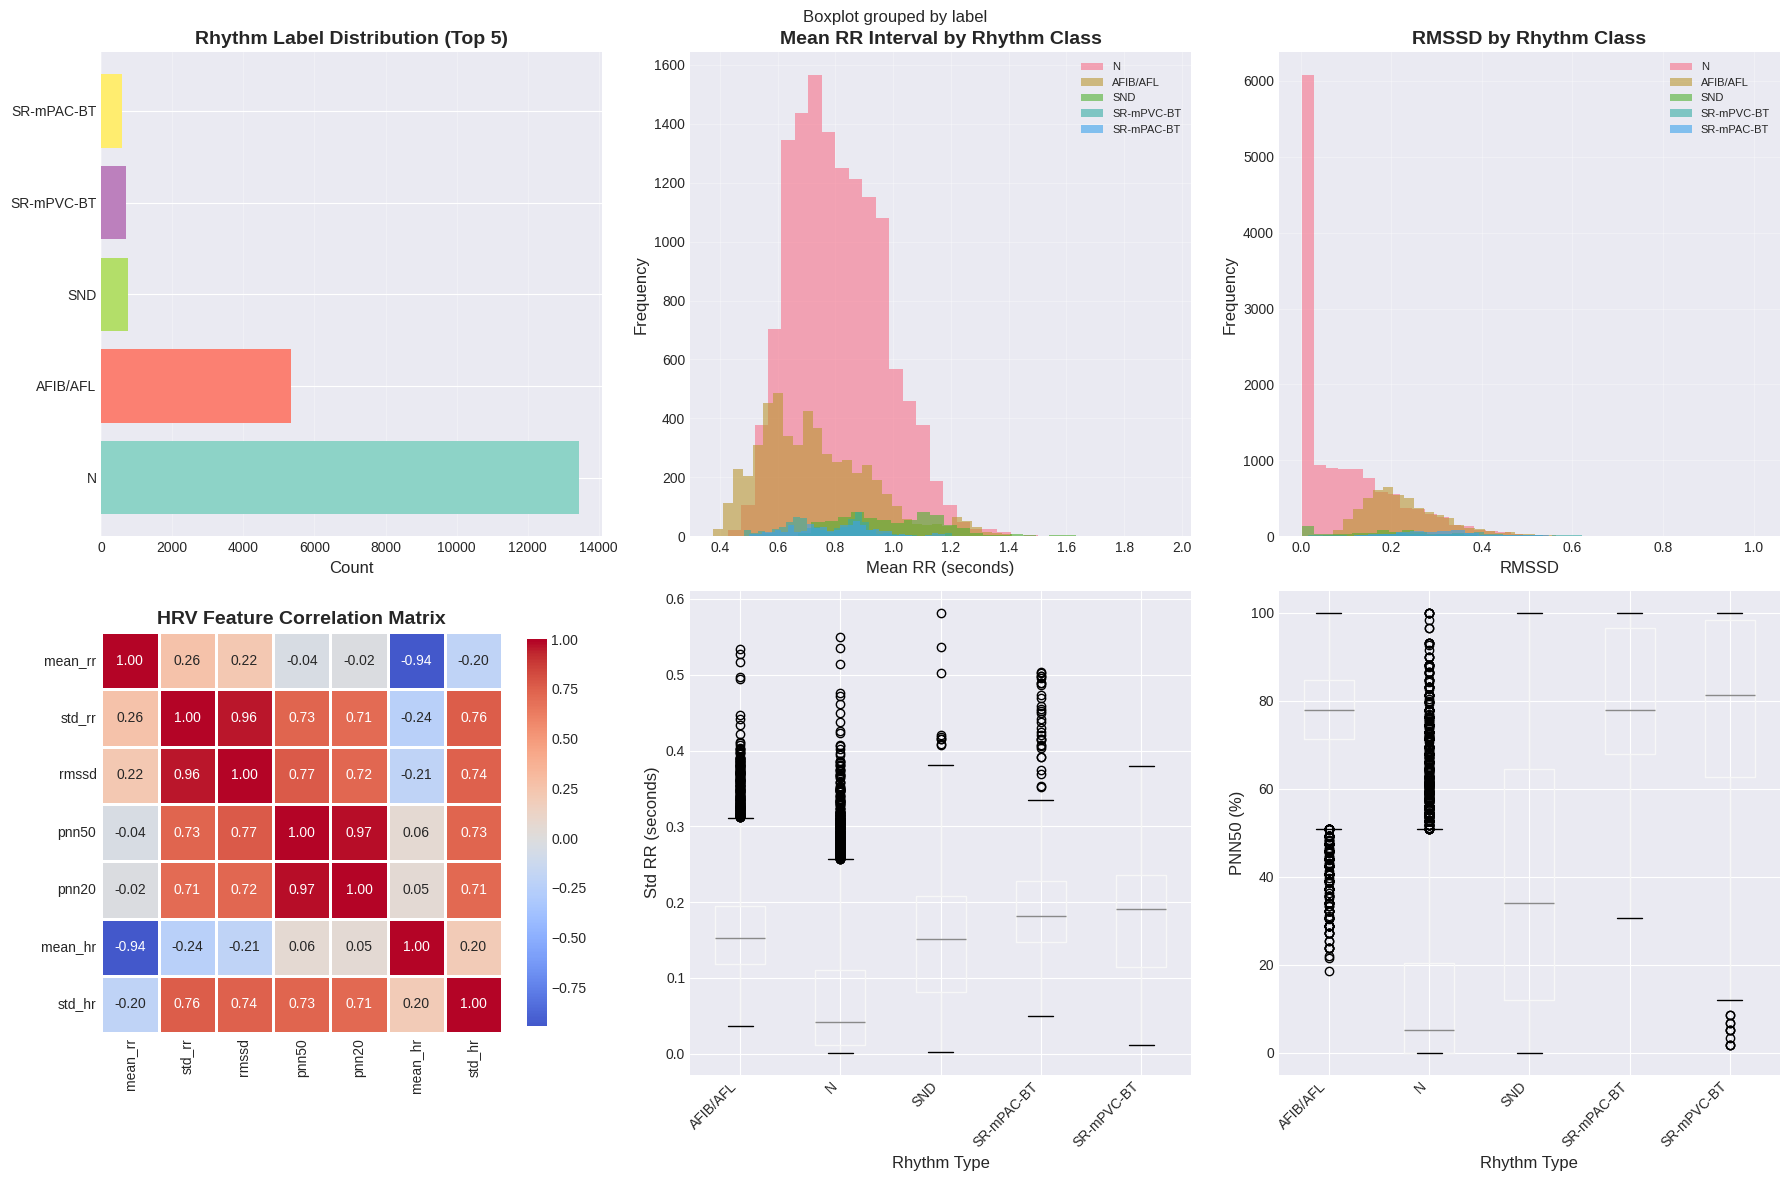


📊 Rhythm Classification Input Summary:
   Total windows: 21603
   Number of HRV features: 10
   Number of classes: 9


In [17]:
# Visualize rhythm classification input features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Filter to top classes for visualization
top_classes = rhythm_features_df['label'].value_counts().head(5).index
rhythm_features_top = rhythm_features_df[rhythm_features_df['label'].isin(top_classes)]

# 1. Label distribution (top classes)
label_counts = rhythm_features_top['label'].value_counts().sort_values(ascending=False)
axes[0, 0].barh(range(len(label_counts)), label_counts.values,
                color=plt.cm.Set3(np.linspace(0, 1, len(label_counts))))
axes[0, 0].set_yticks(range(len(label_counts)))
axes[0, 0].set_yticklabels(label_counts.index)
axes[0, 0].set_title('Rhythm Label Distribution (Top 5)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Count', fontsize=12)
axes[0, 0].grid(axis='x', alpha=0.3)

# 2. Feature distributions by class (mean_rr)
for label in top_classes:
    data = rhythm_features_top[rhythm_features_top['label'] == label]['mean_rr']
    axes[0, 1].hist(data, alpha=0.6, label=label, bins=30)
axes[0, 1].set_title('Mean RR Interval by Rhythm Class', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Mean RR (seconds)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].legend(fontsize=8)
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature distributions by class (rmssd)
for label in top_classes:
    data = rhythm_features_top[rhythm_features_top['label'] == label]['rmssd']
    axes[0, 2].hist(data, alpha=0.6, label=label, bins=30)
axes[0, 2].set_title('RMSSD by Rhythm Class', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('RMSSD', fontsize=12)
axes[0, 2].set_ylabel('Frequency', fontsize=12)
axes[0, 2].legend(fontsize=8)
axes[0, 2].grid(True, alpha=0.3)

# 4. Feature correlation heatmap
corr_features = ['mean_rr', 'std_rr', 'rmssd', 'pnn50', 'pnn20', 'mean_hr', 'std_hr']
corr_data = rhythm_features_df[corr_features].corr()
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=axes[1, 0],
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
axes[1, 0].set_title('HRV Feature Correlation Matrix', fontsize=14, fontweight='bold')

# 5. Box plot: std_rr by class (top 5)
rhythm_features_top.boxplot(column='std_rr', by='label', ax=axes[1, 1])
axes[1, 1].set_title('RR Interval Std Dev by Rhythm Class', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Rhythm Type', fontsize=12)
axes[1, 1].set_ylabel('Std RR (seconds)', fontsize=12)
axes[1, 1].set_title('')
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# 6. Box plot: pnn50 by class (top 5)
rhythm_features_top.boxplot(column='pnn50', by='label', ax=axes[1, 2])
axes[1, 2].set_title('PNN50 by Rhythm Class', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Rhythm Type', fontsize=12)
axes[1, 2].set_ylabel('PNN50 (%)', fontsize=12)
axes[1, 2].set_title('')
plt.setp(axes[1, 2].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n📊 Rhythm Classification Input Summary:")
print(f"   Total windows: {len(rhythm_features_df)}")
print(f"   Number of HRV features: {len([col for col in rhythm_features_df.columns if col not in ['window_idx', 'label']])}")
print(f"   Number of classes: {len(rhythm_features_df['label'].unique())}")


## Section 8: Rhythm Classification - Model Output Visualization


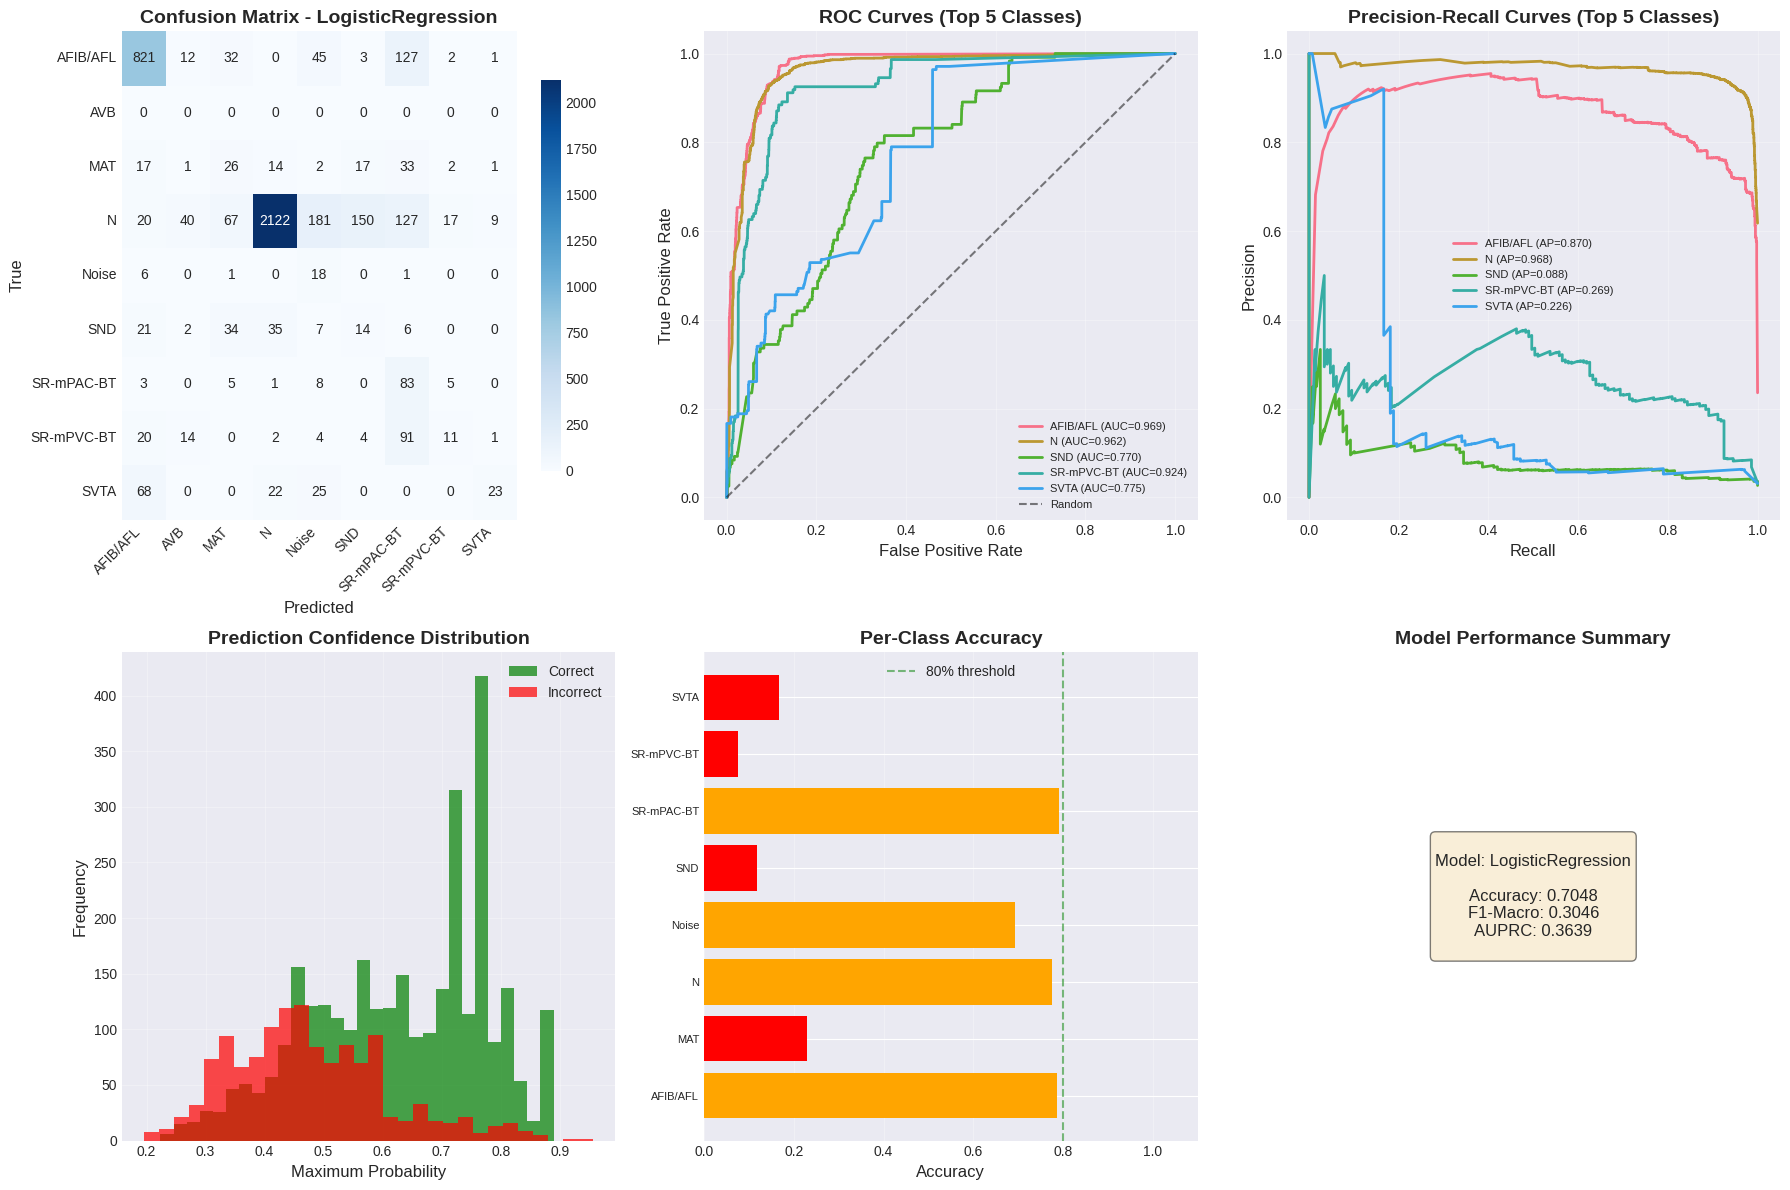


✅ Rhythm classification output visualizations complete!


In [18]:
# Visualize rhythm classification outputs
if rhythm_ml_predictions:
    test_true = rhythm_ml_predictions['test_true_str']
    test_pred = rhythm_ml_predictions['test_pred_str']
    test_proba = rhythm_ml_predictions['test_proba']
    label_encoder = rhythm_ml_predictions['label_encoder']
    
    # Filter to top classes for visualization
    top_classes = pd.Series(test_true).value_counts().head(5).index.tolist()
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(test_true, test_pred, labels=label_encoder.classes_)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
                cbar_kws={"shrink": 0.8})
    axes[0, 0].set_title(f'Confusion Matrix - {rhythm_ml_predictions.get("model_name", "ML Model")}', 
                        fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Predicted', fontsize=12)
    axes[0, 0].set_ylabel('True', fontsize=12)
    plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.setp(axes[0, 0].yaxis.get_majorticklabels(), rotation=0)
    
    # 2. ROC Curves (Top 5 classes)
    y_true_binary = label_binarize(test_true, classes=label_encoder.classes_)
    for i, class_name in enumerate(label_encoder.classes_):
        if class_name in top_classes:
            fpr, tpr, _ = roc_curve(y_true_binary[:, i], test_proba[:, i])
            auc_score = roc_auc_score(y_true_binary[:, i], test_proba[:, i])
            axes[0, 1].plot(fpr, tpr, label=f'{class_name} (AUC={auc_score:.3f})', linewidth=2)
    axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
    axes[0, 1].set_title('ROC Curves (Top 5 Classes)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
    axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
    axes[0, 1].legend(fontsize=8)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Precision-Recall Curves (Top 5 classes)
    for i, class_name in enumerate(label_encoder.classes_):
        if class_name in top_classes:
            precision, recall, _ = precision_recall_curve(y_true_binary[:, i], test_proba[:, i])
            ap = average_precision_score(y_true_binary[:, i], test_proba[:, i])
            axes[0, 2].plot(recall, precision, label=f'{class_name} (AP={ap:.3f})', linewidth=2)
    axes[0, 2].set_title('Precision-Recall Curves (Top 5 Classes)', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Recall', fontsize=12)
    axes[0, 2].set_ylabel('Precision', fontsize=12)
    axes[0, 2].legend(fontsize=8)
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Prediction confidence distribution
    max_proba = np.max(test_proba, axis=1)
    correct_mask = np.array(test_true) == np.array(test_pred)
    axes[1, 0].hist(max_proba[correct_mask], bins=30, alpha=0.7, label='Correct', color='green')
    axes[1, 0].hist(max_proba[~correct_mask], bins=30, alpha=0.7, label='Incorrect', color='red')
    axes[1, 0].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Maximum Probability', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Per-class accuracy (all classes)
    class_acc = []
    class_names_list = []
    for class_name in label_encoder.classes_:
        mask = np.array(test_true) == class_name
        if mask.sum() > 0:
            acc = (np.array(test_pred)[mask] == class_name).mean()
            class_acc.append(acc)
            class_names_list.append(class_name)
    
    colors = ['green' if a > 0.8 else 'orange' if a > 0.6 else 'red' for a in class_acc]
    axes[1, 1].barh(range(len(class_names_list)), class_acc, color=colors)
    axes[1, 1].set_yticks(range(len(class_names_list)))
    axes[1, 1].set_yticklabels(class_names_list, fontsize=8)
    axes[1, 1].axvline(x=0.8, color='green', linestyle='--', alpha=0.5, label='80% threshold')
    axes[1, 1].set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Accuracy', fontsize=12)
    axes[1, 1].set_xlim([0, 1.1])
    axes[1, 1].legend()
    axes[1, 1].grid(axis='x', alpha=0.3)
    
    # 6. Metrics summary
    metrics = rhythm_ml_predictions.get('metrics', {})
    metrics_text = f"\nModel: {rhythm_ml_predictions.get('model_name', 'Unknown')}\n\n"
    metrics_text += f"Accuracy: {metrics.get('accuracy', 0):.4f}\n"
    metrics_text += f"F1-Macro: {metrics.get('f1_macro', 0):.4f}\n"
    if 'auroc_macro' in metrics:
        metrics_text += f"AUROC: {metrics.get('auroc_macro', 0):.4f}\n"
    if 'auprc_macro' in metrics:
        metrics_text += f"AUPRC: {metrics.get('auprc_macro', 0):.4f}\n"
    
    axes[1, 2].text(0.5, 0.5, metrics_text, ha='center', va='center', fontsize=12,
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1, 2].set_xlim([0, 1])
    axes[1, 2].set_ylim([0, 1])
    axes[1, 2].axis('off')
    axes[1, 2].set_title('Model Performance Summary', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Rhythm classification output visualizations complete!")
else:
    print("⚠️  Rhythm ML predictions not loaded. Please run trad_ml.ipynb first.")


In [19]:
# Summary of ML model performance
print("=" * 70)
print("ML MODELS VISUALIZATION SUMMARY")
print("=" * 70)

if beat_ml_predictions:
    beat_metrics = beat_ml_predictions.get('metrics', {})
    print("\n📊 Beat Classification:")
    print(f"   Model: {beat_ml_predictions.get('model_name', 'Unknown')}")
    print(f"   Accuracy: {beat_metrics.get('accuracy', 0):.4f}")
    print(f"   F1-Macro: {beat_metrics.get('f1_macro', 0):.4f}")
    if 'auroc_macro' in beat_metrics:
        print(f"   AUROC: {beat_metrics.get('auroc_macro', 0):.4f}")
    if 'auprc_macro' in beat_metrics:
        print(f"   AUPRC: {beat_metrics.get('auprc_macro', 0):.4f}")

if rhythm_ml_predictions:
    rhythm_metrics = rhythm_ml_predictions.get('metrics', {})
    print("\n📊 Rhythm Classification:")
    print(f"   Model: {rhythm_ml_predictions.get('model_name', 'Unknown')}")
    print(f"   Accuracy: {rhythm_metrics.get('accuracy', 0):.4f}")
    print(f"   F1-Macro: {rhythm_metrics.get('f1_macro', 0):.4f}")
    if 'auroc_macro' in rhythm_metrics:
        print(f"   AUROC: {rhythm_metrics.get('auroc_macro', 0):.4f}")
    if 'auprc_macro' in rhythm_metrics:
        print(f"   AUPRC: {rhythm_metrics.get('auprc_macro', 0):.4f}")

print("\n📋 Note:")
print("   • Visualizations show window-level predictions (60-beat windows)")
print("   • Input features are HRV features extracted from each window")
print("   • Results are directly comparable with DL models (same granularity)")
print("=" * 70)


ML MODELS VISUALIZATION SUMMARY

📊 Beat Classification:
   Model: XGBoost
   Accuracy: 0.7617
   F1-Macro: 0.4424
   AUPRC: 0.4796

📊 Rhythm Classification:
   Model: LogisticRegression
   Accuracy: 0.7048
   F1-Macro: 0.3046
   AUPRC: 0.3639

📋 Note:
   • Visualizations show window-level predictions (60-beat windows)
   • Input features are HRV features extracted from each window
   • Results are directly comparable with DL models (same granularity)
